In [1]:
# Standard Library Imports (if any)

# Third-party Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML
from adjustText import adjust_text

# Local Module Imports
from utils import *
from data_handling import *
from plot import *


In [2]:
data_manager = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
data_manager.clean_and_save_data()

# Access datasets
cpis = data_manager.get_dataset("cpis")
ds = data_manager.get_dataset("ds")
fed = data_manager.get_dataset("fed")
wb = data_manager.get_dataset("wb")
wfe = data_manager.get_dataset("wfe")
gdp = data_manager.get_dataset("gdp")

In [6]:
countries = DS.CODES
cpis = cpis.get_data(issuers="WR", holders=countries, periods=range(2001,2005)).droplevel(level="Counterpart Country")
gdp = gdp.iloc[:,2:6]
wb = wb.loc[DS.CODES, 2001:2004]

In [7]:
y = (cpis/gdp).mean(axis=1)
X_1 = (gdp/wb).mean(axis=1)
X_2 = cpis.calculate_excess_returns_matrix(fed, ds, (1990,2023), True).mean(axis=1)
X_3 = cpis.calculate_excess_returns_matrix(fed, ds, (2001,2004), True).var(axis=1)
X = pd.concat([X_1, X_2, X_3], axis=1, keys=["gdp/cap", "mean", "variance"])
X = sm.add_constant(X)
model = sm.OLS(y,X).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     4.278
Date:                Sun, 23 Mar 2025   Prob (F-statistic):             0.0117
Time:                        10:54:45   Log-Likelihood:                 7.7198
No. Observations:                  37   AIC:                            -7.440
Df Residuals:                      33   BIC:                           -0.9959
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1978      0.054      3.653      0.0

c:\Users\nilsv\OneDrive\School\KUL - MME\Home bias\master-thesis-home-bias\src\data_handling\data_sources\cpis.py:107: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = ds_filled.pct_change(axis=1)


In [8]:
pd.concat([X,y], axis=1)

,const,gdp/cap,mean,variance,0
Country,,,,,
AR,1.0,5.412022,0.000458,0.014300,0.051133
AT,1.0,5.539115,0.002227,0.001810,0.163206
BE,1.0,1.659289,0.003129,0.003231,0.434947
BR,1.0,2.858613,0.004350,0.014063,0.004452
CA,1.0,0.978196,0.004755,0.002544,0.299845
CL,1.0,1.103161,0.006158,0.003559,0.104192
CO,1.0,6.959086,0.003161,0.004510,0.005303
CZ,1.0,6.839691,0.006778,0.003553,0.027306
DK,1.0,1.931627,0.006731,0.003673,0.250002


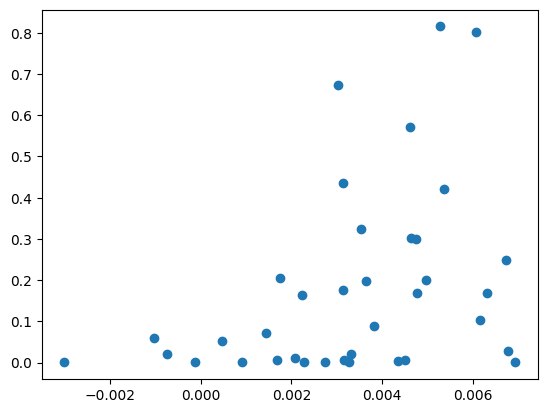

In [9]:
plt.scatter(X["mean"], y)

In [10]:
cpis

,2001,2002,2003,2004
Country,,,,
AR,6.813367e+09,6.768558e+09,7.466369e+09,8.462171e+09
AT,3.118979e+10,3.004735e+10,4.415069e+10,5.493486e+10
BE,1.063306e+11,1.058105e+11,1.412465e+11,1.613803e+11
BR,2.989560e+09,2.380206e+09,2.489316e+09,2.237000e+09
CA,2.307669e+11,2.034614e+11,2.759101e+11,3.198402e+11
CL,3.946359e+09,4.526167e+09,1.072989e+10,1.554924e+10
CO,3.376600e+08,4.215800e+08,7.934751e+08,5.953478e+08
CZ,1.894040e+09,2.868674e+09,1.845209e+09,3.403577e+09
DK,4.808550e+10,3.594024e+10,5.211830e+10,6.771819e+10
